In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import re
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Bidirectional, Input, Embedding, Dropout
from tensorflow.keras.models import Model
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.stem
import pickle
from nltk.corpus import stopwords

In [2]:
indices = collections.deque()
for path, dirs, files in os.walk("data"):
    if len(dirs)==0:
        stem = path.split("/")[-1]+"/"
        for file in files:
            indices.append(stem+file)
newsdf = pd.DataFrame(index=np.unique(indices), columns=["Text", "Summary", "Category"])

In [3]:
newsdf.Category = np.vectorize(lambda s: s.split("/")[0])(newsdf.index.values)
for path, dirs, files in os.walk("data"):
    if len(dirs)==0:
        stem = path.split("/")[-1]+"/"
        col = "Text" if "articles" in path else "Summary"
        for file in files:
            newsdf.loc[stem+file, col] = open(path+"/"+file, "rb").read()

In [4]:
def bytedecoder(string):
    try:
        string = string.decode('utf-8')
        return string
    except:
        return np.nan
for col in ['Text', 'Summary']:
    newsdf[col] = newsdf[col].apply(bytedecoder)
newsdf.dropna(how="any", inplace=True)
newsdf.drop_duplicates(inplace=True)

In [5]:
STOP_WORD_SET = set(word for word in stopwords.words("english") if len(word)<=5)
STOP_WORD_SET-=set(["not","none","never","can't","no","nor"])
def cleaner(s, rem_stop_words=False):
    s = re.sub("\n"," ", re.sub("[,<>@#\'\")(]","", s))
    s = re.sub("\?", " ? ",re.sub("-"," - ", s))
    #NLTK Stemming to Reduce Domain Vocabulary Size
    s = " ".join(np.vectorize(lambda s: s if len(s)<=3 else nltk.stem.WordNetLemmatizer().lemmatize(s))
                 (np.array(s.split())))
    if  rem_stop_words:
        s = " ".join([word for word in s.split() if word not in STOP_WORD_SET])
    return BeautifulSoup(s, "lxml").text.lower()
for col in ['Text', 'Summary']:
    newsdf[col] = newsdf[col].apply(lambda s: cleaner(s, False))
newsdf['Summary'] = "_START "+newsdf['Summary']

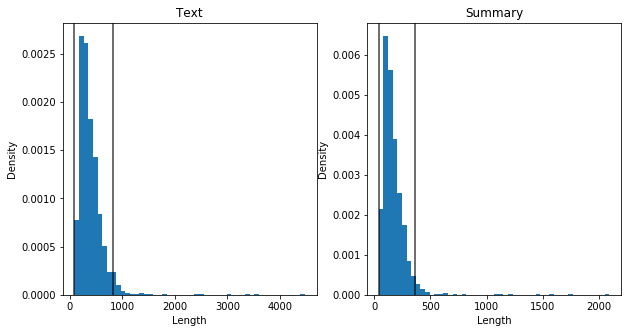

In [6]:
plt.figure(figsize=(10,5))
for col, plot in [('Text', 1), ('Summary', 2)]:
    plt.subplot(1,2,plot)
    lengths = newsdf[col].apply(lambda s: len(s.split()))
    plt.hist(lengths, bins=50, density=True)
    quants = lengths.quantile([0.25,0.75])
    plt.axvline(np.maximum(np.min(lengths), quants[0.25]-1.5*quants.diff().values[-1]), color="black", alpha=0.75)
    plt.axvline(quants[0.75]+1.5*quants.diff().values[-1], color="black", alpha=0.75)
    plt.xlabel("Length")
    plt.ylabel("Density")
    plt.title(col)

In [9]:
#Set maximum lengths at 1000 for text to limit Universal Sentence Encoder lengths
MAX_TEXT_LEN = 1000
MAX_SUMMARY_LEN = 500
newsdf.drop(newsdf[(newsdf['Text'].apply(lambda s: len(s.split()))>MAX_TEXT_LEN)|(newsdf['Summary'].apply(
    lambda s: len(s.split()))>MAX_SUMMARY_LEN)].index, inplace=True)

In [10]:
def padtokens(series, pad, length):
    token = tf.keras.preprocessing.text.Tokenizer()
    token.fit_on_texts(series)
    words = token.texts_to_sequences(series)
    words = tf.keras.preprocessing.sequence.pad_sequences(words, maxlen=length, padding=pad)
    return words, token
texts, texttoken = padtokens(newsdf['Text'], "pre", MAX_TEXT_LEN)
summs, summtoken = padtokens(newsdf['Summary'], "post", MAX_SUMMARY_LEN)

In [11]:
np.random.seed(1)
testindices = np.random.choice(np.arange(texts.shape[0]), np.int(0.2*texts.shape[0]), replace=False)
trainindices = np.unique(list(set(np.arange(texts.shape[0]))-set(testindices)))
trainX, testX = texts[trainindices], texts[testindices]
trainY, testY = summs[trainindices], summs[testindices]
trainX.shape, trainY.shape, testX.shape, testY.shape

((1680, 1000), (1680, 500), (420, 1000), (420, 500))

In [12]:
#Save processed output
np.savez_compressed("./data/modeldata", trainX=trainX, trainY=trainY, testX=testX, testY=testY)
pickle.dump(texttoken, open("./data/token_text.pkl", "wb"))
pickle.dump(summtoken, open("./data/token_summary.pkl", "wb"))
newsdf.to_csv("./data/cleannewsdata.csv")